In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set(rc={'figure.figsize':(15,8.27)})
sns.set(style="whitegrid")

In [2]:
data_path = '../../data/Tatoeba/data/release/v2021-08-07/eng-hun'

In [8]:
!ls "$data_path"

README.md  test.src		     train.combined.cleaned_4	  train.src
dev.id	   test.trg		     train.combined.cleaned_4_32  train.trg
dev.src    train.combined.cleaned_1  train.combined.cleaned_4_64
dev.trg    train.combined.cleaned_2  train.combined.cleaned_5
test.id    train.combined.cleaned_3  train.id


In [3]:
src_line_lengths = []
with open(os.path.join(data_path, 'train.src')) as source_file:
    for line in source_file:
        src_line_lengths.append(len(line.split(' ')))

## Visualizations of the sentence lengths

<AxesSubplot:ylabel='Count'>

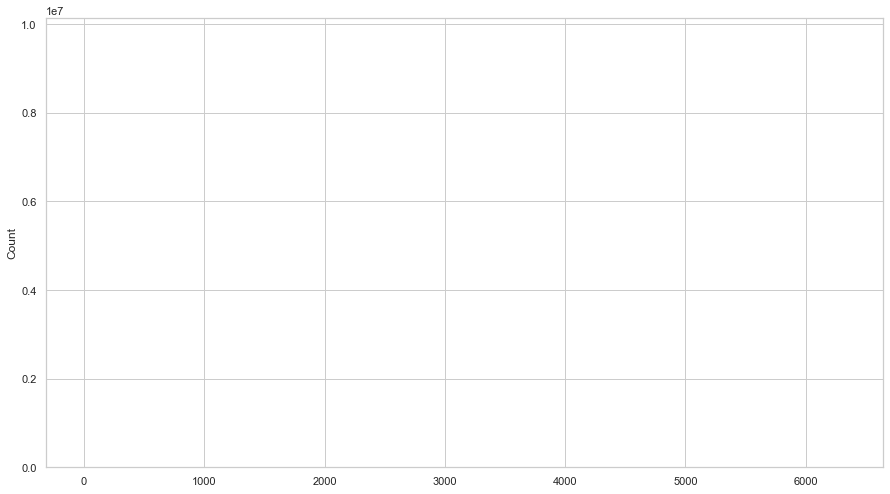

In [6]:
sns.histplot(src_line_lengths)

<AxesSubplot:ylabel='Frequency'>

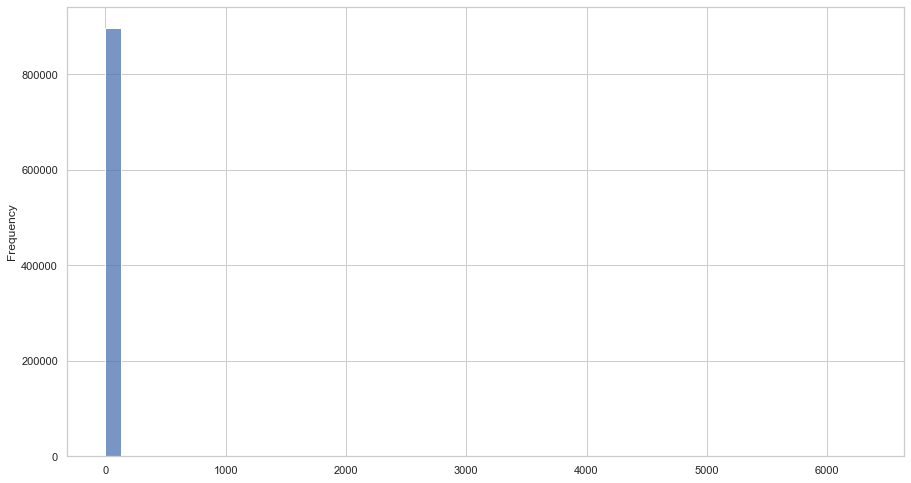

In [35]:
sns.histplot(src_line_lengths, bins=50, stat='frequency')

<AxesSubplot:ylabel='Frequency'>

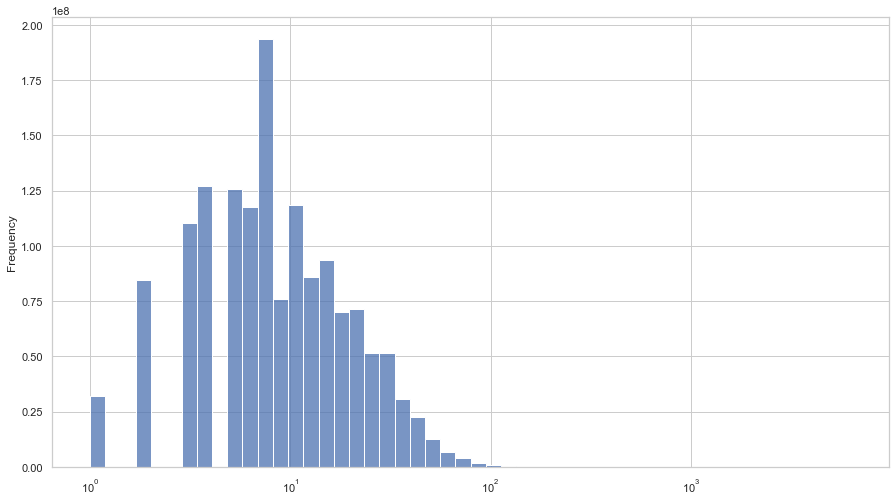

In [37]:
sns.histplot(src_line_lengths, log_scale=True, bins=50, stat='frequency')

In [6]:
src_line_lengths[:10]

[23, 150, 26, 108, 22, 47, 34, 40, 58, 55]

In [4]:
sorted_src_line_lengths = sorted(src_line_lengths)

In [11]:
sorted_src_line_lengths[-20:]

[2476,
 2480,
 2499,
 2525,
 2552,
 2563,
 2616,
 2622,
 2847,
 2979,
 3024,
 3039,
 3166,
 3447,
 3532,
 3744,
 4031,
 4038,
 4474,
 6327]

In [12]:
len(src_line_lengths)

113408329

In [14]:
sorted_src_line_lengths[-1000]

230

<AxesSubplot:ylabel='Frequency'>

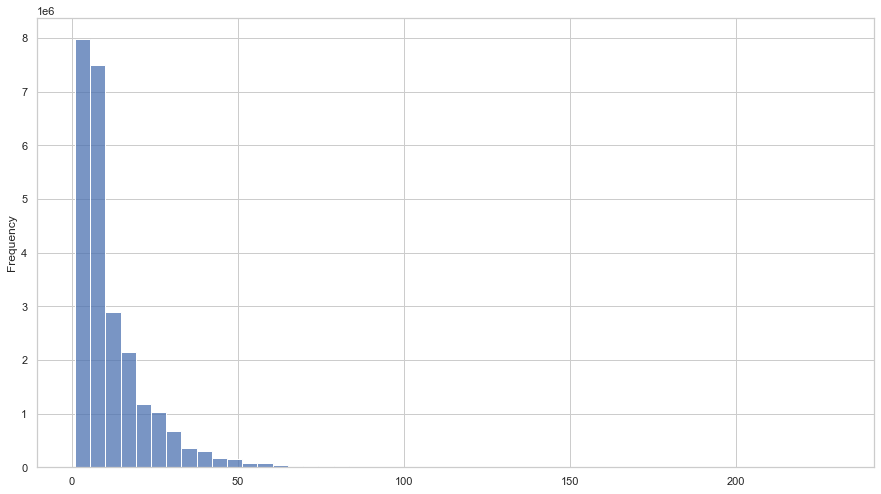

In [38]:
sns.histplot(sorted_src_line_lengths[:-1000], bins=50, stat='frequency')

In [97]:
len(src_line_lengths)

113408329

In [5]:
np_lens = np.array(sorted_src_line_lengths)

In [6]:
np_lens_64 = np_lens[np.where(np_lens <= 64)]
np_lens_32 = np_lens[np.where(np_lens <= 32)]

[Text(0.5, 0, 'HUN - Sentence length (word count capped at 32)'),
 Text(0, 0.5, 'Frequency')]

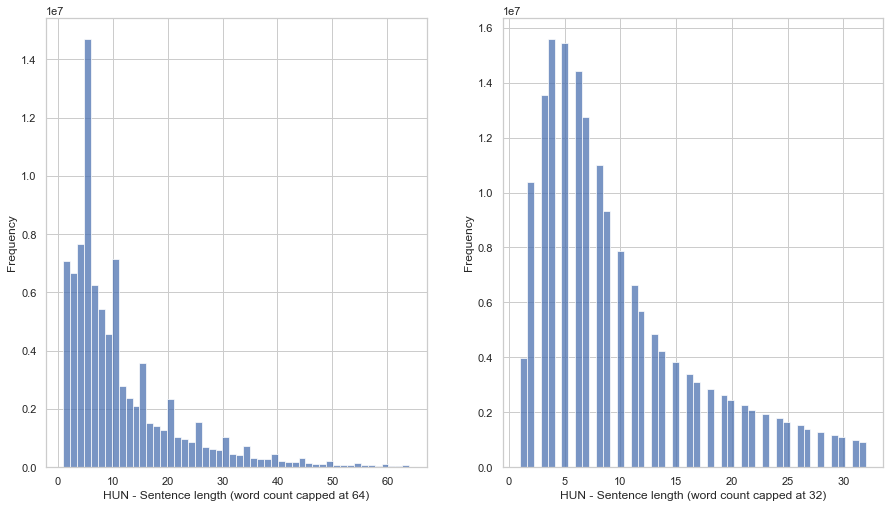

In [31]:
fig, axs = plt.subplots(1,2)
sns.histplot(np_lens_64, bins=50, stat='frequency', ax=axs[0])
axs[0].set(xlabel='HUN - Sentence length (word count capped at 64)', ylabel='Frequency')
sns.histplot(np_lens_32, bins=50, stat='frequency', ax=axs[1])
axs[1].set(xlabel='HUN - Sentence length (word count capped at 32)', ylabel='Frequency')

In [13]:
quantiles = [0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
np.quantile(np_lens, quantiles)

array([  5.,   8.,  15.,  26.,  57., 100.])

In [14]:
print(f'mean: {np_lens.mean()}')
print(f'median: {np.median(np_lens)}')
print(f'max: {np_lens.max()}')
print(f'min: {np_lens.min()}')

mean: 11.8940908564132
median: 8.0
max: 6327
min: 1


## Deduplication

The number of duplicate sentences in the source and in the target datasets do not match.

combine the sentences

In [15]:
for dataset in ['train', 'dev', 'test']:
    with open(os.path.join(data_path, f'{dataset}.src')) as source_file:
        with open(os.path.join(data_path, f'{dataset}.trg')) as target_file:
            with open(os.path.join(data_path, f'{dataset}.combined'), 'w') as combined_file:
                for src_line, tgt_line in zip(source_file, target_file):
                    combined_file.write(src_line.strip('\n'))
                    combined_file.write('\t')
                    combined_file.write(tgt_line.strip('\n'))
                    combined_file.write('\n')

In [37]:
for dataset in ["train", "dev", "test"]:
    !sort "$data_path"/"$dataset".combined > "$data_path"/"$dataset".combined.sorted
    !uniq "$data_path"/"$dataset".combined.sorted > "$data_path"/"$dataset".combined.uniq

In [39]:
!wc -l "$data_path"/*.combined

   97144 data/release/v2021-08-07/eng-hun/dev.combined
   13037 data/release/v2021-08-07/eng-hun/test.combined
 113408329 data/release/v2021-08-07/eng-hun/train.combined
 113518510 total


In [40]:
!wc -l "$data_path"/*.combined.uniq

   97144 data/release/v2021-08-07/eng-hun/dev.combined.uniq
   13037 data/release/v2021-08-07/eng-hun/test.combined.uniq
 108362780 data/release/v2021-08-07/eng-hun/train.combined.uniq
 108472961 total


In [41]:
113408329-108362780

5045549

In [45]:
5045549/113408329

0.04449010971672107

Save the results

In [68]:
with open(os.path.join(data_path, 'train.combined.uniq'), 'r') as combined_file:
    with open(os.path.join(data_path, 'train_dedup.src'), 'w') as source_file:
        with open(os.path.join(data_path, 'train_dedup.trg'), 'w') as target_file:
            for line in combined_file:
                source_line, target_line = line.split('\t')
                source_file.write(source_line)
                source_file.write('\n')
                target_file.write(target_line)
                target_file.write('\n')

## Sampling data from greater than 64 word lengths 

In [6]:
sampled_words_nums_greater_64 = np.random.choice(np_lens[np.where(np_lens >= 64)], size=(20,), replace=False)
sampled_words_nums_greater_64

array([ 64,  74,  83,  81,  64,  80,  84,  86,  68,  70,  66,  97, 113,
       187, 105,  89,  65, 243,  66,  65])

In [20]:
def sample_sentences(word_lengths, file):
    with open(os.path.join(data_path, file)) as source_file:
        for line in source_file:
            word_count = len(line.split(' '))
            for i, num in enumerate(word_lengths):
                if word_count == num:
                    print(f'{num}: {line}')
                    word_lengths = np.delete(word_lengths, i)
                    break
            if len(word_lengths) == 0:
                break

In [21]:
sample_sentences(sampled_words_nums_greater_64, 'train_dedup.src')

80: ฀ ) NT E R NATIONAL฀ # I VI L฀ ! VI A TION฀ / R G AN IS A TION฀ ) NT E R NATIONAL฀ M AfiR I TIME฀ DANGEROUS ฀ GOODS฀ CO DE ฀ %UROPEAN฀AGREEMENT฀CONCERNING฀THE฀INTERNATIONAL฀ CARRIAGE฀ OF฀ DANGEROUS ฀ GOODS฀ BY฀ INLAND฀ WATER W A Y S฀ %UROPEAN฀AGREEMENT฀CONCERNING฀THE฀INTERNATIONAL฀ CARRIAGE฀ OF฀ DANGEROUS ฀ GOODS฀ BY฀ R O A D฀ 2 E G U L A TIONS฀ CONCERNING฀ THE฀ INTERNATIONAL฀ CARRIAGE฀ OF฀ DANGEROUS ฀ GOODS฀ BY฀ R A I L

74: ฀ C ฀a ฀ r ฀ t ฀a ฀ g ฀ e ฀ n ฀a฀฀ ฀ P ฀ r ฀ o ฀t฀o ฀ c ฀ o ฀ l ฀ ฀ ฀o฀n฀฀ ฀ B ฀ i ฀ o ฀s฀a฀f฀e฀t฀y฀฀ ฀i฀n฀฀ ฀t฀r฀a฀n฀s฀b฀o฀u฀n฀d฀a฀r฀y฀฀ ฀ m ฀ o ฀ v ฀ e ฀ m ฀ e ฀ n ฀ t ฀ , ฀ ฀ ฀ t ฀ r ฀a ฀ n ฀ s ฀i฀t ฀ , ฀ ฀

65: ฀฀฀Y฀o฀u฀฀฀c฀a฀n฀฀฀s฀u฀b฀s฀c฀r฀i฀b฀e฀฀฀t฀o฀฀฀i฀t฀฀฀o฀n฀l฀i฀n฀e฀฀฀a฀t h t t p : / / e c . e u r o p a . e u / e m p l o y m e n t _ s o c i a l / e m p l w e b / n e w s / e s m a i l _ e n . c f m

65: ฀ a ฀ ฀ ฀ d ฀ a ฀ i ฀ l ฀ y ฀ ฀ ฀ e ฀ x ฀ p ฀ o ฀ s ฀ u ฀ r ฀ e ฀ ฀ ฀ a ฀ c ฀ t ฀ i ฀ o ฀ n ฀ ฀ ฀v฀a฀l฀u฀e฀฀ ฀ o ฀ f ฀ ฀ ฀ 2 ฀ . ฀ 5 ฀ ฀ ฀ m

105: ฀a

187: By way of example, are considered as corresponding to a normal conduct of business goods shipped to distribution centres for the importing companies, or when the importer can present a contract or letter of credit preceding the date of shipment, or when the goods have been transhipped outside China onto another means of transport within a reasonably short period of time.The increases to the agreed levels introduced by the Regulation are made available to enable the issuance of import licences for goods shipped to the Community between 13 and 19 July 2005, or for goods shipped to the Community after 20 July 2005 with a valid Chinese export licence, which are in excess of the agreed levels introduced by Commission Regulation (EC) No 1084/2005 (OJ L 177, 9.7.2005, p. 19) in Annex V to Regulation (EEC) No 3030/93.Should any goods shipped to the Community between 13 and 19 July 2005 exceed these levels, the Commission may authorise the issuance of further import licences after informin

## Sampling data from between 32 and 64 word lengths

In [15]:
sampled_words_nums_between_32_64 = np.random.choice(np_lens[np.where((np_lens >= 32) & (np_lens <= 64))], size=(20,), replace=False)
sampled_words_nums_between_32_64

array([42, 41, 61, 49, 45, 36, 43, 46, 34, 42, 37, 46, 33, 35, 44, 40, 34,
       41, 41, 48])

In [22]:
sample_sentences(sampled_words_nums_between_32_64, 'train_dedup.src')

46: ฀ (AVE฀ CORRECT฀ PERSONAL฀ HYGIENE฀ RULES฀ BEEN฀ IMPLE MENT ED฀ H AND฀ WAS H ING฀ CHAN G ING฀ OF ฀C L O THE S฀ B AN฀ ON฀ EATING฀ DRINKING฀ OR฀ SMOKING฀ AT฀WORK ฀ POST S฀ E T C ฀AND฀IS฀THEIR฀APPLICA TION฀ M ON IT OR E D

46: Ā«InvincibleĀ» Corian - many people mistakenly believe this material is the most durable and strong.Eventually worktop Corian also covered with scratches or stains from tea.The only advantage of this material is that it can be easily restored.But this procedure can be trusted only to specialists. 

48: ☀️ Hourly weather forecast is best weather app! ✨Hourly weather forecast also provides current atmospheric pressure, weather condition, visibility distance, relative humidity, precipitation in different unites, dew point, wind speed and direction, in addition to ten days future forecast and hourly hourly weather forecast.Realtime temperature, humidity, pressure,... 

33: ฀ (AVE฀ ANY฀OTHER฀ DElCIENCIES OR SHORTCOMINGS BEEN DETECTED WITH REGARD TO COLLECTIVE฀ PROTEC

## Sampling data smaller than 32 words

In [23]:
sampled_words_nums_smaller_32 = np.random.choice(np_lens[np.where(np_lens <= 32)], size=(20,), replace=False)
sampled_words_nums_smaller_32

array([ 3, 10,  6, 11,  3,  5,  7, 10, 14, 10,  6,  7, 11, 16, 26, 13, 19,
        4,  5, 17])

In [24]:
sample_sentences(sampled_words_nums_smaller_32, 'train_dedup.src')

16: ฀ " AS ED฀ IN IT I ALL Y ฀ ON฀ A฀ SINGLE฀ $% ฀ VALUE

10: ฀ #ALCULATE฀ THE฀ SAMPLE ฀ MEAN ฀ 9 ฀AND฀THE฀ QUASI

10: ฀ #ALCULATE฀ THE฀ SAMPLE ฀ MEAN ฀ 9 ฀AND฀THE฀ QUASI

4: ฀ & )2%฀02%6%.4)/. /BJECTIVE฀

19: ฀ ,6฀ FOR฀ SAMPLES ฀ OF฀ ฀ L IT R ES฀ TO฀ ฀ L IT R ES฀ ; =

10: ฀ ,6฀ FOR฀ ฀ L฀AIR฀ SAMPLES ฀ ; > 4%#(.)#!,฀#(!2!#4%2)34)#3

7: ฀ ,6฀ TO฀ ฀ MG M ฀

6: ฀ AND฀ FOL LOW฀ THE฀ PRO

11: ฀ A฀SIMPLIlED METHODOLOGY FOR ASSESSING THE RISK OF AN฀ACCIDENT฀RESULTING฀FROM฀THE฀PRESENCE฀OF฀CHEMI CAL฀ AGENTS

5: ─ Ah, don't say it.

5: ─ Ah, it is nothing.

7: ─ Bring her out of it once!

3: ─ But ..

6: ─ Could this be your imagination?

11: ──∆─── Nivolumab (events: 125/208), median and 95% CI: 5.32 (2.83, 7.06)

13: ──∆─── Nivolumab 3 mg/kg (events: 190/292), median and 95% CI: 12.19 (9.66, 14.98)

3: ฀ OF฀ METHOXY

17: ──────LOVE▄████▄▄████▄ ─────LOVE▐▀████████████▌ ─────LOVE▐█▄▓██████████▌ ──────LOVE▀███████████▀ ────────LOVE▀███████▀ ──────────LOVE▀███▀ ────────────____█ MyPleasureXXX ─---

## Trying to filter out the trash

### Cleaning 1: remove CLD2 problems

In [53]:
!grep -v "CLD2: problems with line" "$data_path"/train.combined.uniq > "$data_path"/train.combined.cleaned_1

In [54]:
!wc -l "$data_path"/train.combined.uniq

 108362780 data/release/v2021-08-07/eng-hun/train.combined.uniq


In [55]:
!wc -l "$data_path"/train.combined.cleaned_1

 108301972 data/release/v2021-08-07/eng-hun/train.combined.cleaned_1


In [77]:
108362780-108301972

60808

### Cleaning 2: remove or replace forbidden characters

In [85]:
character_set = 'ÁÉÍÓÖÚÜáäéíóöúüŐőŰűščABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789' + ' ,฀.;-[@_!#$%^&*()<>?/\|}{~:]"”„“' + "'’‘"
character_replace = [('õ', 'ő'), ('ô', 'ő'), ('û', 'ű'), ('è', 'é'), ('─', '-'), ('‑', '-'), ('–', '-'), ('—', '-')]
source_forbidden_chars = {}
target_forbidden_chars = {}

In [86]:
%%time
with open(os.path.join(data_path, 'train.combined.cleaned_1'), 'r') as combined_file:
    with open(os.path.join(data_path, 'train.combined.cleaned_2'), 'w') as output_file:
        for line in combined_file:
            source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
            is_clean_sentence = True

            # replace characters in sentences
            for from_char, to_char in character_replace:
                source_sent = source_sent.replace(from_char, to_char)
                target_sent = target_sent.replace(from_char, to_char)
            
            # check source sentence for forbidden characters
            if source_sent[0] not in character_set:
                source_sent = source_sent[1:]
            for i, character in enumerate(source_sent):
                if character not in character_set:
                    is_clean_sentence = False
                    if character in source_forbidden_chars:
                        source_forbidden_chars[character] += 1
                    else:
                        source_forbidden_chars[character] = 1
#                     print('chr: ', character, 'code: ', ord(character), ' source_line: ', source_sent)
#                     break

#             if not is_clean_sentence:
#                 continue
    
            # check target sentence for forbidden characters
            if target_sent[0] not in character_set:
                target_sent = target_sent[1:]
            for character in target_sent:
                if character not in character_set:
                    is_clean_sentence = False
                    if character in target_forbidden_chars:
                        target_forbidden_chars[character] += 1
                    else:
                        target_forbidden_chars[character] = 1
#                     print('chr: ', character, 'code: ', ord(character), ' target_line: ', target_sent)
#                     break
                    
            if not is_clean_sentence:
                continue
                
            output_file.write(source_sent)
            output_file.write('\t')
            output_file.write(target_sent)
            output_file.write('\n')

CPU times: user 28min 28s, sys: 29 s, total: 28min 58s
Wall time: 29min 9s


In [88]:
!wc -l "$data_path"/train.combined.cleaned_1

 108301972 data/release/v2021-08-07/eng-hun/train.combined.cleaned_1


In [89]:
!wc -l "$data_path"/train.combined.cleaned_2

 104536279 data/release/v2021-08-07/eng-hun/train.combined.cleaned_2


In [92]:
108301972-104536279

3765693

In [80]:
[f'{k}: {v}' for k, v in sorted(source_forbidden_chars.items(), key=lambda item: item[1], reverse=True)][:50]

['\xa0: 520320',
 '…: 443995',
 '+: 439476',
 '=: 176061',
 '\u200b: 129118',
 '€: 123934',
 '�: 105667',
 '»: 94151',
 '°: 92616',
 '♪: 91483',
 '\ufeff: 89056',
 '®: 67915',
 '©: 63809',
 '•: 62843',
 '`: 48266',
 'ä: 44356',
 '™: 35348',
 'š: 34772',
 '→: 32151',
 '«: 31936',
 '£: 30506',
 'à: 30009',
 'č: 29703',
 'è: 29180',
 '´: 27893',
 'â: 26591',
 '›: 25873',
 '·: 24300',
 '×: 24125',
 'ă: 22636',
 'ç: 22451',
 'ñ: 21145',
 'ā: 20212',
 '\xad: 19876',
 '≥: 19141',
 'ć: 16851',
 'õ: 14892',
 '\u2005: 14787',
 'ș: 14510',
 '²: 14444',
 '▪: 14185',
 '±: 13899',
 'Š: 13405',
 'ž: 13144',
 'ô: 12883',
 'ã: 12692',
 '≤: 12000',
 'ø: 11936',
 '′: 11796',
 'ş: 11750']

In [79]:
[f'{k}: {v}' for k, v in sorted(target_forbidden_chars.items(), key=lambda item: item[1], reverse=True)][:50]

['\xa0: 840749',
 'õ: 558041',
 '+: 491321',
 '…: 401286',
 '�: 221229',
 '=: 180238',
 '»: 179692',
 'û: 123619',
 '«: 95611',
 '\u200b: 92645',
 '°: 85987',
 '€: 73240',
 'ô: 72240',
 '\xad: 70999',
 '®: 64544',
 '\ufeff: 61800',
 '•: 59899',
 '©: 44905',
 'è: 44222',
 'ä: 42861',
 'ı: 35743',
 '™: 31960',
 'š: 31531',
 'č: 28719',
 '×: 27864',
 '→: 27780',
 '§: 26453',
 '›: 25707',
 '·: 24432',
 'â: 24264',
 'ç: 24189',
 'ï: 20538',
 'ă: 20359',
 'ć: 20297',
 'à: 19927',
 '│: 19104',
 '£: 16383',
 'ñ: 15515',
 '≥: 15245',
 '±: 15071',
 'ā: 15044',
 '−: 14418',
 'Š: 14396',
 '²: 14342',
 '▪: 14192',
 'ã: 13702',
 'Ã: 13512',
 'ł: 12960',
 'ș: 12902',
 'ž: 11838']

### Cleaning 3: Look at average word lengths in the sentences

In [5]:
def average_word_length(sent):
    sent_word_cnt = len(sent.split(' '))
    return (len(sent) - sent_word_cnt) / sent_word_cnt

In [3]:
%%time
source_word_lengths = []
target_word_lengths = []
with open(os.path.join(data_path, 'train.combined.cleaned_2'), 'r') as combined_file:
    for line in combined_file:
        source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
        
        source_word_lengths.append(average_word_length(source_sent))
        target_word_lengths.append(average_word_length(target_sent))
            
np_src_wl = np.array(sorted(source_word_lengths))
np_tgt_wl = np.array(sorted(target_word_lengths))

CPU times: user 7min 34s, sys: 29.2 s, total: 8min 3s
Wall time: 8min 14s


In [4]:
np_src_wl[-10:]

array([ 483.  ,  488.  ,  494.  ,  496.  ,  648.  ,  763.  ,  821.  ,
        824.  ,  920.  , 1260.25])

In [15]:
def stats(np_array):
    quantiles = [0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
    return {
        'mean': np_array.mean(),
        'median': np.median(np_array),
        'max': np_array.max(),
        'min': np_array.min(),
        'std': np_array.std(),
        'quantiles': {k: v for k, v in zip(quantiles, np.quantile(np_array, quantiles))}
    }

In [120]:
stats(np_src_wl)

mean: 4.848306552744089
median: 4.666666666666667
max: 1260.25
min: 0.0
quantiles: [0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
[ 4.          4.66666667  5.4         6.28571429 10.         17.        ]


In [122]:
stats(np_tgt_wl)

mean: 6.06060144814083
median: 5.923076923076923
max: 920.0
min: 0.0
quantiles: [0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
[ 5.          5.92307692  6.91666667  8.         12.         21.        ]


[Text(0.5, 0, 'HUN - average word length'), Text(0, 0.5, 'Frequency')]

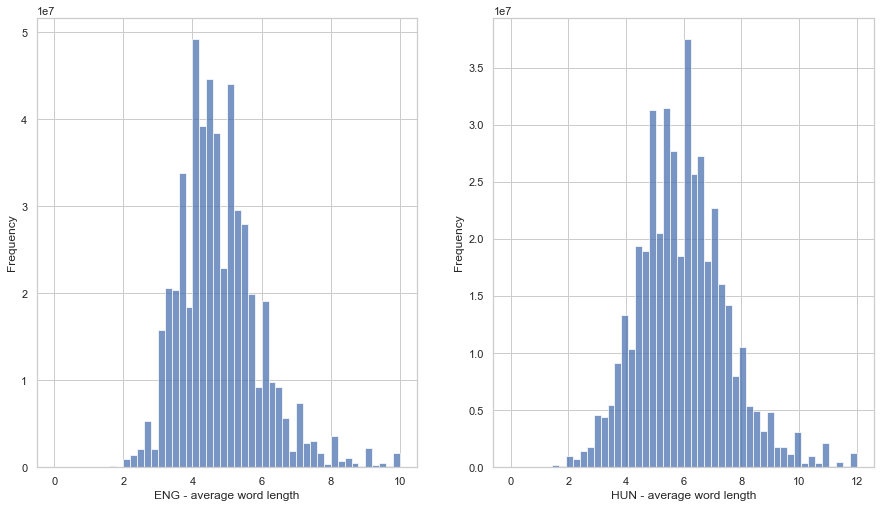

In [123]:
fig, axs = plt.subplots(1,2)
sns.histplot(np_src_wl[np.where(np_src_wl <= 10)], bins=50, stat='frequency', ax=axs[0])
axs[0].set(xlabel='ENG - average word length', ylabel='Frequency')
sns.histplot(np_tgt_wl[np.where(np_tgt_wl <= 12)], bins=50, stat='frequency', ax=axs[1])
axs[1].set(xlabel='HUN - average word length', ylabel='Frequency')

In [113]:
len(np_src_wl[np.where(np_src_wl > 10)])

954116

In [ ]:
len(np_src_wl[np.where(np_src_wl <= 10)])

Look at samples from the lower part

In [16]:
sample_cnt = 40
i = 0
with open(os.path.join(data_path, 'train.combined.cleaned_2'), 'r') as combined_file:
    for line in combined_file:
        source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
        if average_word_length(source_sent) < 2:
            print(source_sent, target_sent)
            i += 1
            if i >= sample_cnt:
                break

฀ #( ! . ' % ฀/ & ฀ & / 2฀ / 2฀ 0 ( 9 3 ) # ! , ฀ 3 4 ! 4 % $ESCRIPTION A FORMA VAGY A FIZIKAI ÁLLAPOT MEGVÁLTOZTATÁSA
฀ , ฀ ฀ ฀w฀h฀i฀c฀h฀฀ ฀ e ฀ n ฀ t ฀ e ฀ r ฀ e ฀ d ฀ ฀ ฀i฀n฀t฀o฀฀ ฀f฀o฀r ฀ c ฀ e ฀ ฀ ฀o฀n฀฀ Az új rendelet a környezet védelmét is szem előtt tartja, előírva a környezeti problémák esetén alkalmazandó intézkedéseket (1829/2003/EK rendelet). 3.
฀ ,6฀ TO฀ ฀ MG M ฀ 3, 15 l levegőmintára vonatkozóan [1].
฀ A ฀ s ฀ ฀฀ a ฀ ฀฀ m ฀ o ฀ b ฀ i ฀ l ฀ e ฀฀ Alapelvként az EU/EGT-országok polgárai valamennyi tagállamban szabadon gyakorolhatják szakmájukat.
฀ C ฀ H ฀ L ฀ O ฀ R ฀ I ฀ N ฀ E KLÓRMENTES FEHÉR PAPÍRRA NYOMTATVA
฀ C ฀a ฀ r ฀ t ฀a ฀ g ฀ e ฀ n ฀a฀฀ ฀ P ฀ r ฀ o ฀t฀o ฀ c ฀ o ฀ l ฀ ฀ ฀o฀n฀฀ ฀ B ฀ i ฀ o ฀s฀a฀f฀e฀t฀y฀฀ ฀i฀n฀฀ ฀t฀r฀a฀n฀s฀b฀o฀u฀n฀d฀a฀r฀y฀฀ ฀ m ฀ o ฀ v ฀ e ฀ m ฀ e ฀ n ฀ t ฀ , ฀ ฀ ฀ t ฀ r ฀a ฀ n ฀ s ฀i฀t ฀ , ฀ ฀ A szabályozás védzáradékot tartalmaz, amely előírja, hogy amennyiben egy tagállam elégséges indokkal rendelkezik annak feltételezésére, hogy egy írásbeli forga

In [17]:
len(np_src_wl[np.where(np_src_wl < 2)])

68313

Look at samples from the upper part

In [24]:
sample_cnt = 40
i = 0
with open(os.path.join(data_path, 'train.combined.cleaned_2'), 'r') as combined_file:
    for line in combined_file:
        source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
        if average_word_length(source_sent) == 10:
            print(source_sent, target_sent)
            i += 1
            if i >= sample_cnt:
                break

Aquatic attractant DMPT Dimethlpropiothetin) Vízi vonzó DMPT Dimethlpropiothetin)
Installation: Wall-mounted screws telepítés: falra szerelt csavarok
Eradication A betegség felszámolása
production advantages; termelési előnyök;
Additional information Kiegészítő információk
Crustaceans Rákok
Land-based closed (recirculation) Zárt (recirkulációs) szárazföldi üzem
coordination failures. koordinációs hiányosságok.
production advantages; termelési előnyök;
Description Leírás
Eradication Felszámolás
Freshwater closed (recirculation) Zárt (recirkulációs) édesvizű üzem
Vaccination Vakcinázás
winery infrastructure, borászati infrastruktúra
computer-related crime számítógépes bűncselekmények
continuous evaluation. folyamatos értékelés.
nformation: nformáció:
Enable/disable block notification Engedélyezése / tiltása block értesítést
Intangible investment: Nem tárgyi befektetés:
Vaccination Vakcinázás
corruption; vesztegetés;
Contractors Alvállalkozók
Marylouise (@mareelow) Laura Barna (@lunaawvag

In [27]:
with open(os.path.join(data_path, 'train.combined.cleaned_2'), 'r') as combined_file:
    with open(os.path.join(data_path, 'train.combined.cleaned_3'), 'w') as output_file:
        for line in combined_file:
            source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
            if 2 <= average_word_length(source_sent) <= 10:
                output_file.write(source_sent)
                output_file.write('\t')
                output_file.write(target_sent)
                output_file.write('\n')

In [29]:
!wc -l "$data_path"/train.combined.cleaned_2

 104536279 data/release/v2021-08-07/eng-hun/train.combined.cleaned_2


In [28]:
!wc -l "$data_path"/train.combined.cleaned_3

 103513850 data/release/v2021-08-07/eng-hun/train.combined.cleaned_3


In [30]:
104536279-103513850

1022429

### Cleaning 4: Remove sentences with greater than 1.6 word count ratio

In [3]:
src_line_lengths = []
with open(os.path.join(data_path, 'train.combined.cleaned_3')) as source_file:
    for line in source_file:
        source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
        src_line_lengths.append(len(source_sent.split(' ')))
np_lens = np.array(sorted(src_line_lengths))
len(np_lens)

103513850

In [6]:
stats(np_lens)

{'mean': 11.867501373004675,
 'median': 8.0,
 'max': 2314,
 'min': 1,
 'std': 11.548513754462391,
 'quantiles': {0.25: 5.0,
  0.5: 8.0,
  0.75: 15.0,
  0.9: 26.0,
  0.99: 56.0,
  0.999: 97.0}}

In [47]:
src_line_lengths = []
with open(os.path.join(data_path, 'test.src')) as source_file:
    for line in source_file:
        src_line_lengths.append(len(line.split(' ')))
np_lens = np.array(sorted(src_line_lengths))
len(np_lens)

13037

In [48]:
stats(np_lens)

mean: 6.098335506634962
median: 5.0
max: 58
min: 1
quantiles: [0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
[ 4.  5.  7. 10. 17. 28.]


In [4]:
%%time

char_count_diffs = []
word_count_diffs = []
char_count_ratios = []
word_count_ratios = []

with open(os.path.join(data_path, 'train.combined.cleaned_3'), 'r') as combined_file:
    for line in combined_file:
        source_sent, target_sent = [sent.strip() for sent in line.split('\t')]

        source_word_count = len(source_sent.split(' '))
        target_word_count = len(target_sent.split(' '))

        char_count_diffs.append(abs(len(source_sent) - len(target_sent)))
        word_count_diffs.append(abs(source_word_count - target_word_count))
        
        char_count_ratios.append(len(source_sent) / len(target_sent))
        word_count_ratios.append(source_word_count / target_word_count)

char_count_diffs = np.array(char_count_diffs)
word_count_diffs = np.array(word_count_diffs)
char_count_ratios = np.array(char_count_ratios)
word_count_ratios = np.array(word_count_ratios)

CPU times: user 9min 13s, sys: 39 s, total: 9min 52s
Wall time: 9min 49s


In [5]:
char_count_diffs_stats = stats(char_count_diffs)
char_count_diffs_stats

{'mean': 11.970325603771862,
 'median': 7.0,
 'max': 39056,
 'min': 0,
 'std': 20.477286266315893,
 'quantiles': {0.25: 3.0,
  0.5: 7.0,
  0.75: 14.0,
  0.9: 26.0,
  0.99: 84.0,
  0.999: 230.0}}

In [6]:
word_count_diffs_stats = stats(word_count_diffs)
word_count_diffs_stats

{'mean': 2.629283520997432,
 'median': 2.0,
 'max': 3480,
 'min': 0,
 'std': 3.6577935627580587,
 'quantiles': {0.25: 1.0,
  0.5: 2.0,
  0.75: 3.0,
  0.9: 6.0,
  0.99: 16.0,
  0.999: 36.0}}

In [7]:
char_count_ratios_stats = stats(char_count_ratios)
char_count_ratios_stats

{'mean': 1.0562279365134877,
 'median': 1.0,
 'max': 292.0,
 'min': 0.0029940119760479044,
 'std': 0.7102688459744181,
 'quantiles': {0.25: 0.8548387096774194,
  0.5: 1.0,
  0.75: 1.1470588235294117,
  0.9: 1.3703703703703705,
  0.99: 2.4444444444444446,
  0.999: 7.166666666666668}}

In [8]:
word_count_ratios_stats = stats(word_count_ratios)
word_count_ratios_stats

{'mean': 1.285619863312914,
 'median': 1.1818181818181819,
 'max': 263.0,
 'min': 0.0049504950495049506,
 'std': 0.76031259488164,
 'quantiles': {0.25: 1.0,
  0.5: 1.1818181818181819,
  0.75: 1.4210526315789473,
  0.9: 1.75,
  0.99: 3.0,
  0.999: 8.25}}

[Text(0.5, 0, 'Eng-Hun length ratio (word)')]

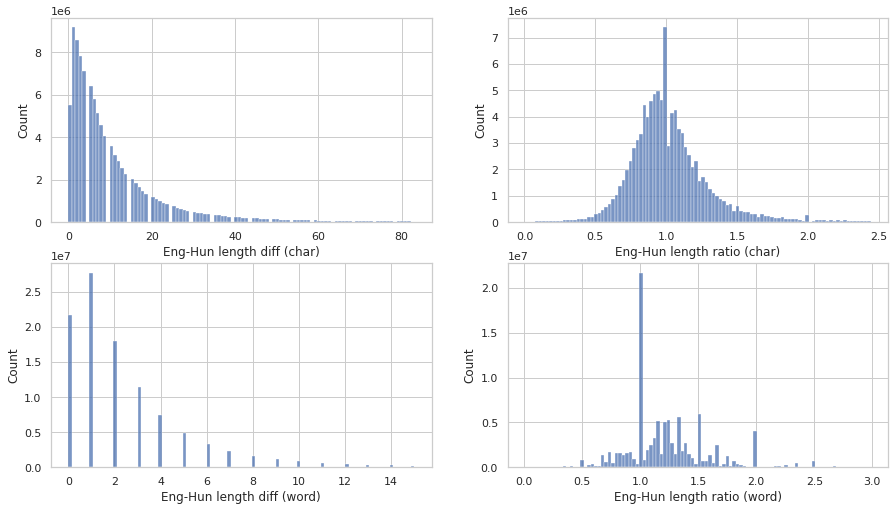

In [11]:
quantile = 0.99
fig, axs = plt.subplots(2,2)

sns.histplot(char_count_diffs[np.where(char_count_diffs < char_count_diffs_stats['quantiles'][quantile])], bins=100, ax=axs[0, 0])
axs[0, 0].set(xlabel='Eng-Hun length diff (char)')

sns.histplot(char_count_ratios[np.where(char_count_ratios < char_count_ratios_stats['quantiles'][quantile])], bins=100, ax=axs[0, 1])
axs[0, 1].set(xlabel='Eng-Hun length ratio (char)')

sns.histplot(word_count_diffs[np.where(word_count_diffs < word_count_diffs_stats['quantiles'][quantile])], bins=100, ax=axs[1, 0])
axs[1, 0].set(xlabel='Eng-Hun length diff (word)')

sns.histplot(word_count_ratios[np.where(word_count_ratios < word_count_ratios_stats['quantiles'][quantile])], bins=100, ax=axs[1, 1])
axs[1, 1].set(xlabel='Eng-Hun length ratio (word)')

In [11]:
with open(os.path.join(data_path, 'train.combined.cleaned_3'), 'r') as combined_file:
    with open(os.path.join(data_path, 'train.combined.cleaned_4_32'), 'w') as output_file:
        for line in combined_file:
            source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
            
            source_word_count = len(source_sent.split(' '))
            target_word_count = len(target_sent.split(' '))
            
            word_count_diff = abs(source_word_count - target_word_count)
            word_count_ratio = source_word_count / target_word_count
            
            if 0 < source_word_count < 32 and 0 < target_word_count < 32 and (word_count_diff < 8 or 0.5 <= word_count_ratio <= 2):
                output_file.write(source_sent)
                output_file.write('\t')
                output_file.write(target_sent)
                output_file.write('\n')

In [4]:
with open(os.path.join(data_path, 'train.combined.cleaned_3'), 'r') as combined_file:
    with open(os.path.join(data_path, 'train.combined.cleaned_4_64'), 'w') as output_file:
        for line in combined_file:
            source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
            
            source_word_count = len(source_sent.split(' '))
            target_word_count = len(target_sent.split(' '))
            
            word_count_diff = abs(source_word_count - target_word_count)
            word_count_ratio = source_word_count / target_word_count
            
            if 0 < source_word_count < 64 and 0 < target_word_count < 64 and (word_count_diff < 8 or 0.5 <= word_count_ratio <= 2):
                output_file.write(source_sent)
                output_file.write('\t')
                output_file.write(target_sent)
                output_file.write('\n')

In [5]:
!wc -l "$data_path"/train.combined.cleaned_3

103513850 ../../data/Tatoeba/data/release/v2021-08-07/eng-hun/train.combined.cleaned_3


In [6]:
!wc -l "$data_path"/train.combined.cleaned_4_32

95744740 ../../data/Tatoeba/data/release/v2021-08-07/eng-hun/train.combined.cleaned_4_32


In [7]:
!wc -l "$data_path"/train.combined.cleaned_4_64

101606275 ../../data/Tatoeba/data/release/v2021-08-07/eng-hun/train.combined.cleaned_4_64


In [18]:
103513850-95998797

7515053

## Filter based on the ratio of uppercase letters

In [13]:
source_upper_case_ratios = []
target_upper_case_ratios = []
with open(os.path.join(data_path, 'train.combined.cleaned_4_32'), 'r') as combined_file:
        for line in combined_file:
            source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
            
            source_upper_case_ratios.append(len(re.findall(r'[A-Z]', source_sent)) / len(source_sent))
            target_upper_case_ratios.append(len(re.findall(r'[A-Z]', target_sent)) / len(target_sent))

In [12]:
!wc -l "$data_path"/train.combined.cleaned_4_32

95744740 ../../data/Tatoeba/data/release/v2021-08-07/eng-hun/train.combined.cleaned_4_32


In [14]:
len(source_upper_case_ratios)

95744740

In [16]:
source_upper_case_ratios = np.array(source_upper_case_ratios)
target_upper_case_ratios = np.array(target_upper_case_ratios)

In [22]:
source_upper_case_ratios_stats = stats(source_upper_case_ratios)
source_upper_case_ratios_stats

{'mean': 0.060487286674062016,
 'median': 0.04,
 'max': 1.0,
 'min': 0.0,
 'std': 0.07877501574836802,
 'quantiles': {0.25: 0.022222222222222223,
  0.5: 0.04,
  0.75: 0.075,
  0.9: 0.125,
  0.99: 0.3076923076923077,
  0.999: 1.0}}

In [23]:
target_upper_case_ratios_stats = stats(target_upper_case_ratios)
target_upper_case_ratios_stats

{'mean': 0.047739318053032824,
 'median': 0.03225806451612903,
 'max': 1.0,
 'min': 0.0,
 'std': 0.06700687837415877,
 'quantiles': {0.25: 0.016129032258064516,
  0.5: 0.03225806451612903,
  0.75: 0.058823529411764705,
  0.9: 0.1,
  0.99: 0.25,
  0.999: 0.875}}

<AxesSubplot:ylabel='Count'>

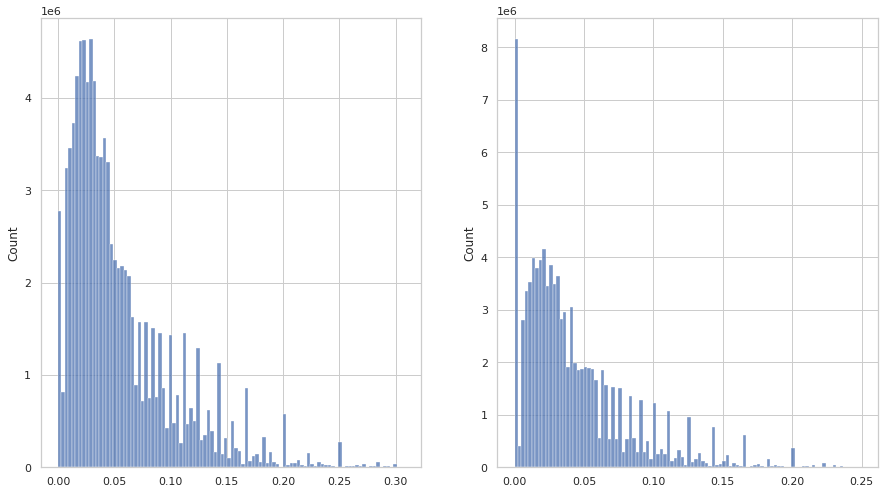

In [27]:
quantile = 0.99
fig, axs = plt.subplots(1, 2)

sns.histplot(source_upper_case_ratios[np.where(source_upper_case_ratios < source_upper_case_ratios_stats['quantiles'][quantile])], bins=100, ax=axs[0])
# axs[0, 0].set(xlabel='Eng-Hun length diff (char)')

sns.histplot(target_upper_case_ratios[np.where(target_upper_case_ratios < target_upper_case_ratios_stats['quantiles'][quantile])], bins=100, ax=axs[1])
# axs[0, 1].set(xlabel='Eng-Hun length ratio (char)')


In [40]:
i = 0
with open(os.path.join(data_path, 'train.combined.cleaned_4_32'), 'r') as combined_file:
        for line in combined_file:
            source_sent, target_sent = [sent.strip() for sent in line.split('\t')]
            
            source_ratio = len(re.findall(r'[A-Z]', source_sent)) / len(source_sent)
            target_ratio = len(re.findall(r'[A-Z]', target_sent)) / len(target_sent)
            
#             if 0.15 > source_ratio > 0.1:
#                 print("source_ratio:", source_ratio)
#                 print(source_sent, target_sent, '\n')
#                 i += 1
            if 0.15 > target_ratio > 0.1:
                print("target_ratio:", target_ratio)
                print(source_sent, target_sent, '\n')
                i += 1
                
            if i > 10:
                break

target_ratio: 0.125
Weather in Manzini Időjárás Manzini 

target_ratio: 0.125
-Seizures Libertek 

target_ratio: 0.125
- House Paradies - - Paradies-Ház - 

target_ratio: 0.11538461538461539
Weather in Rome, Italy Időjárás Róma, Olaszország 

target_ratio: 0.14285714285714285
Mary and Max (Movie) Mary és Max [Színház] 

target_ratio: 0.14285714285714285
E-learning and Education E-Learning és Oktatás 

target_ratio: 0.1111111111111111
News and Media (0) Hírek és Média (0) 

target_ratio: 0.13513513513513514
Previous Next: The Oneness-Heart-Tears and Smiles Next: Egység-Szív-Könnyek és Mosolyok 

target_ratio: 0.12962962962962962
Australia/New Zeland Standards Glass Beads TYPE C Ausztrália / Új-Zéland szabványok Üveggyöngyök C TÍPUS 

target_ratio: 0.1111111111111111
Creativity - YES! Kreativitás, Igen! 

target_ratio: 0.12
Diludine CAS NO.1149-23-1 97% feed additives Diludin CAS NO.1149-23-1 97% takarmány-adalékanyag 



In [41]:
with open(os.path.join(data_path, 'train.combined.cleaned_4_32'), 'r') as combined_file:
    with open(os.path.join(data_path, 'train.combined.cleaned_5'), 'w') as output_file:
        for line in combined_file:
            source_sent, target_sent = [sent.strip() for sent in line.split('\t')]

            source_ratio = len(re.findall(r'[A-Z]', source_sent)) / len(source_sent)
            target_ratio = len(re.findall(r'[A-Z]', target_sent)) / len(target_sent)
            
            if source_ratio < 0.15 and target_ratio < 0.15:
                output_file.write(source_sent)
                output_file.write('\t')
                output_file.write(target_sent)
                output_file.write('\n')

In [42]:
!head -50 "$data_path"/train.combined.cleaned_5

- Ah, don't say it.	- Nem mond ezt.
- Ah, it is nothing.	- Ugyan, semmiség.
- Are you alright?	- Jól vagy?
- Bring her out of it once!	- Hozza vissza azonnal!
- Could this be your imagination?	Lehet, hogy ez a képzelődésed?
- Delicious.	- Fantasztikus.
- He can't get out.	- Ki sem tud jönni.
--What lines were particularly memorable?	- A programok közül melyek voltak különösen emlékezetesek?
Does an old Lada still start after six months under water?	Beindul-e egy Lada, ami hat hónapot töltött a víz alatt?
- Don't, don't ..	- Ne, ne...
Marriage is the alliance of two people, one of whom never remembers birthdays and the other who never forgets them.	A házasság két olyan ember szövetsége, akik közül az egyik sose emlékszik a születésnapokra, a másik meg sose felejti el azokat.
- Oh, yes. Modelling is my business.	- Igen, modellkedéssel foglakozom.
Only 55% of Americans know that it is a star.	Az amerikaiak 55%-a tudja csak, hogy a Nap - egy csillag.
- be hospitable	Legyen vendégszerető
- 

In [44]:
!wc -l "$data_path"/train.combined.cleaned_5

88852480 ../../data/Tatoeba/data/release/v2021-08-07/eng-hun/train.combined.cleaned_5


## Final number of lines

In [56]:
!wc -l "$data_path"/train.combined

 113408329 data/release/v2021-08-07/eng-hun/train.combined


In [45]:
!wc -l "$data_path"/train.combined.cleaned_5

88852480 ../../data/Tatoeba/data/release/v2021-08-07/eng-hun/train.combined.cleaned_5


In [46]:
113408329-88852480

24555849

In [47]:
24555849/113408329

0.21652597491318296